# Toxic Comment Classification

## I - Data Analysis

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, Model

from keras.layers import Dense,Dropout,Input,Embedding,Flatten,TextVectorization,Conv1D,GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.layers import Dense,LSTM,Bidirectional,Attention,Concatenate,GRU,BatchNormalization


# Set up the color scheme
background_color = '#1B1B1B'
line_color = '#7DF9FF'
text_color = 'white'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X = pd.read_csv("./drive/My Drive/kaggle_data/train_x.csv")
y = pd.read_csv("./drive/My Drive/kaggle_data/train_y.csv")
X_val = pd.read_csv("./drive/My Drive/kaggle_data/val_x.csv")
y_val = pd.read_csv("./drive/My Drive/kaggle_data/val_y.csv")
X.head()

,index,string
0,0,even up here.......BLACKS!
1,1,Blame men. There's always an excuse to blame ...
2,2,You have no business making any comments on th...
3,3,"""Let's get the black folks and the white folks..."
4,4,I guess the issue is people not willing to put...


In [ ]:
y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [ ]:
# Size of the training and validation set
print("The size of the training set is ",X.size)
print("The size of the validation set is ",X_val.size)
print()

538076
90360


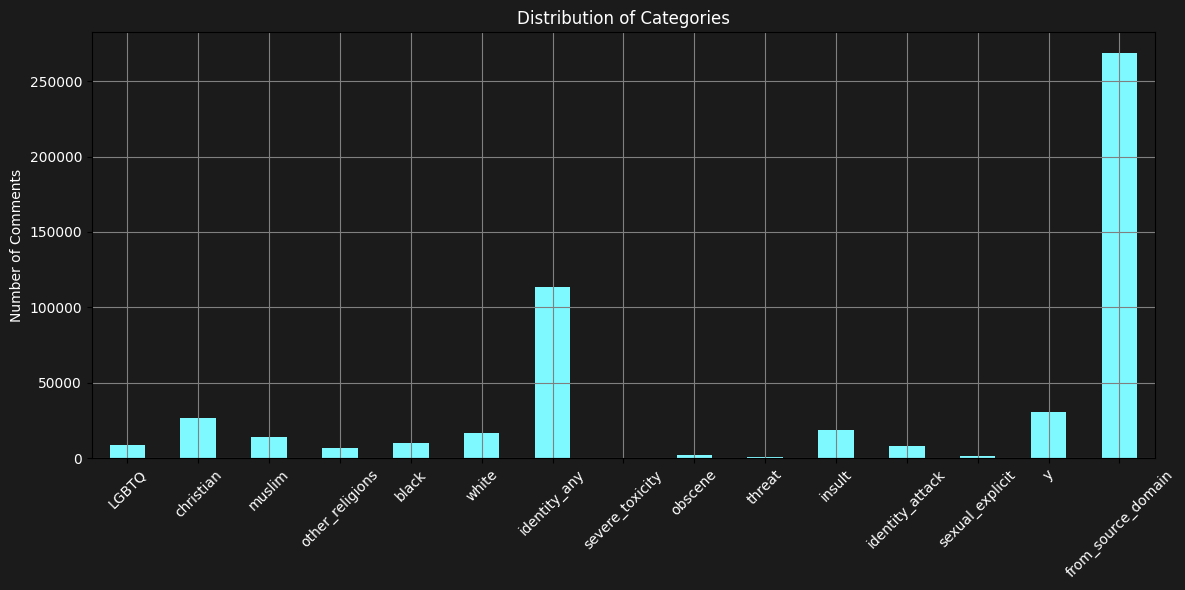

In [ ]:
# Distribution of the number of comments for each categories
categories = y.columns[2:]
y[categories].sum().plot(kind='bar', color='#7DF9FF')

plt.figure(figsize=(12, 6), facecolor=background_color)
plt.gca().set_facecolor(background_color)

plt.title('Distribution of Categories', color=text_color)
plt.ylabel('Number of Comments', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True, color='grey')
plt.tight_layout()
plt.show()

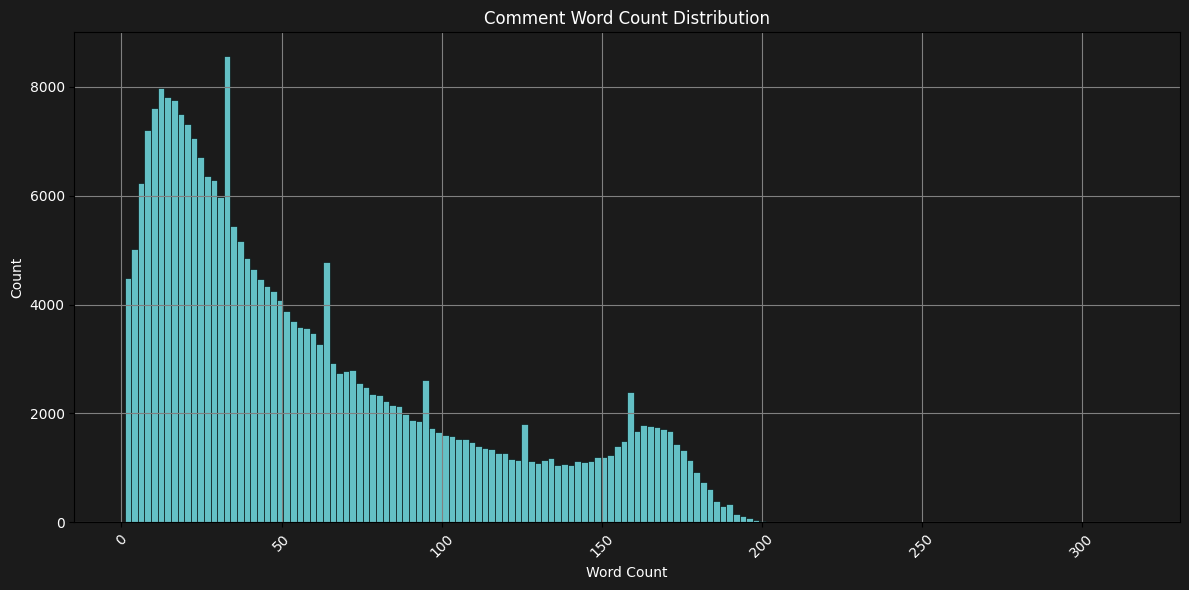

In [ ]:
# Distribution of the word count
X['word_count'] = X['string'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6), facecolor=background_color)
plt.gca().set_facecolor(background_color)
sns.histplot(X['word_count'], color='#7DF9FF')
plt.title('Comment Word Count Distribution', color=text_color)
plt.xlabel('Word Count', color=text_color)
plt.ylabel('Count', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.grid(True, color='grey')
plt.tight_layout()
plt.show()

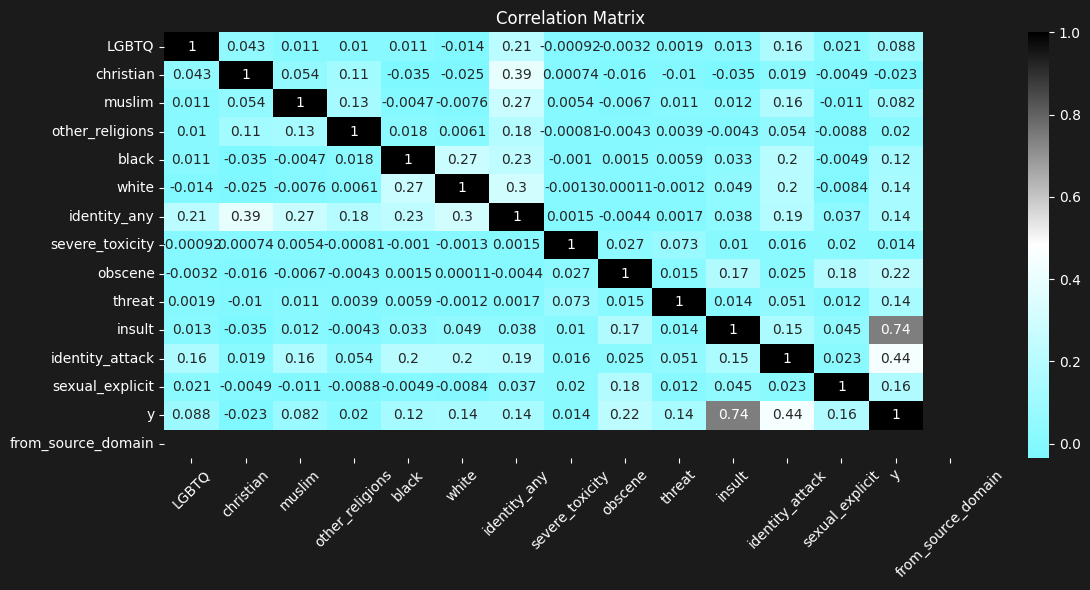

In [ ]:
# Correlation plot in between the different categories and the target variable
from matplotlib.colors import LinearSegmentedColormap
corr = y[categories].corr()

# Define the cmap
electric_blue = "#7DF9FF"
cmap = LinearSegmentedColormap.from_list("custom_electric_blue", [electric_blue, "white", "black"])

plt.figure(figsize=(12, 6), facecolor=background_color)
plt.gca().set_facecolor(background_color)
ax = sns.heatmap(corr, annot=True, cmap=cmap)
plt.title('Correlation Matrix', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.tight_layout()
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')
for label in cbar.ax.get_yticklabels():
    label.set_color('white')
plt.show()

In [ ]:
# Example: Comments that are marked as attacking a specific identity
identity_attack_comments = X[y['identity_attack'] == 1]['string']
print(identity_attack_comments.head())

0                            even up here.......BLACKS!
1     Blame men.  There's always an excuse to blame ...
3     "Let's get the black folks and the white folks...
18    How do we fight agaisnt women who use sexual f...
24    C.Parsons\nIf the terrorists are loathsome for...
Name: string, dtype: object


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
X['string'] = X['string'].astype(str)

# Define a function to clean the text
def clean_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]  # Remove stopwords
    return tokens

# Apply the function to the dataset
X['cleaned_text'] = X['string'].apply(clean_text)

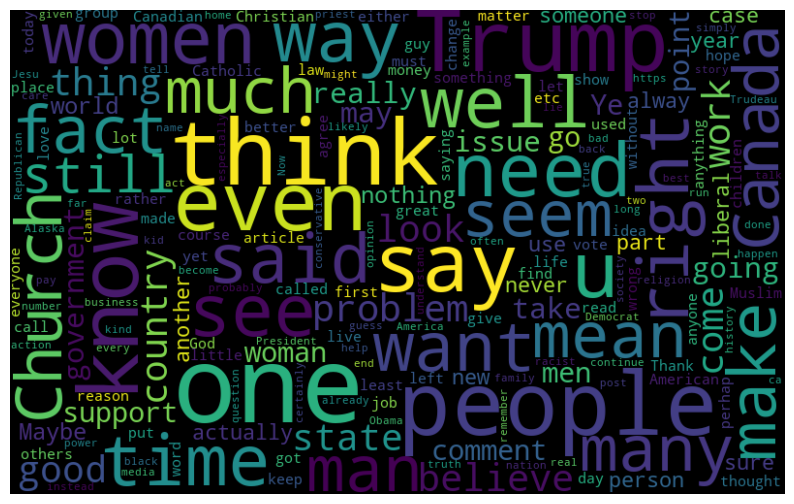

In [ ]:
all_words = ' '.join([word for words_list in X['cleaned_text'] for word in words_list])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Male-targeted comments common words: [('I', 27137), ('men', 14836), ('man', 14644), ('women', 12937), ('The', 10554), ('would', 7252), ('people', 6989), ('one', 6242), ('like', 6028), ('It', 5962)]
Female-targeted comments common words: [('I', 34312), ('women', 29738), ('The', 12759), ('woman', 12134), ('men', 9532), ('would', 9437), ('people', 8563), ('one', 7802), ('like', 7596), ('It', 7574)]
LGBTQ-targeted comments common words: [('I', 8196), ('gay', 4691), ('people', 3515), ('The', 3298), ('would', 2249), ('one', 1917), ('It', 1855), ('like', 1703), ('women', 1519), ('You', 1267)]


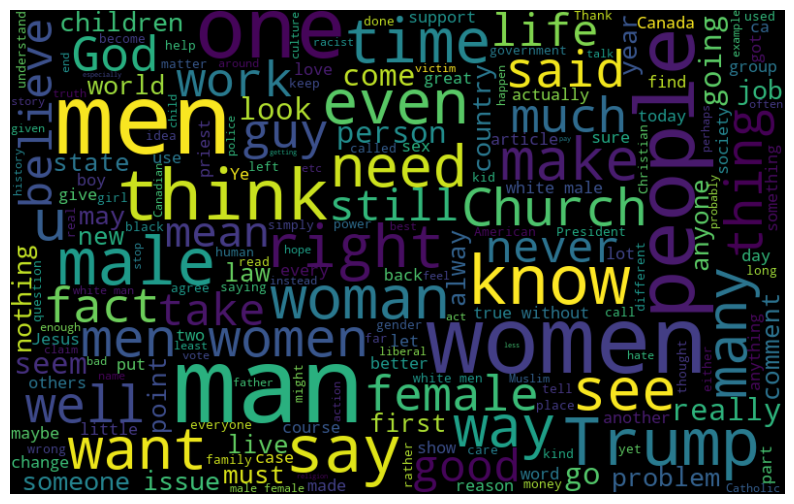

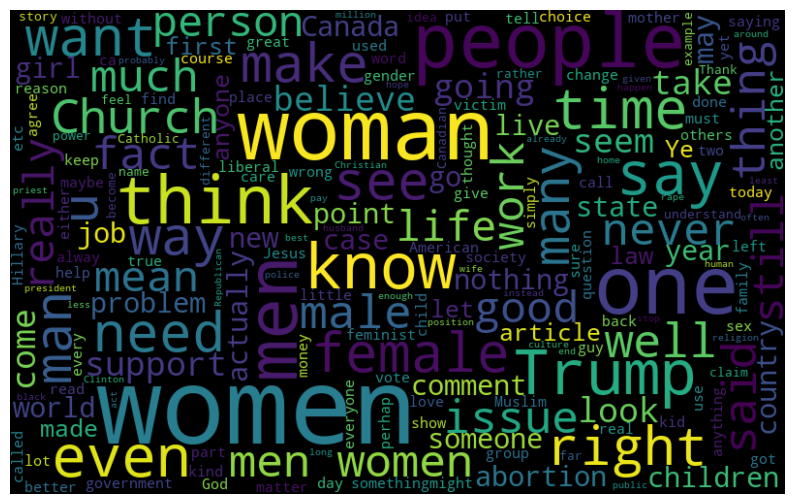

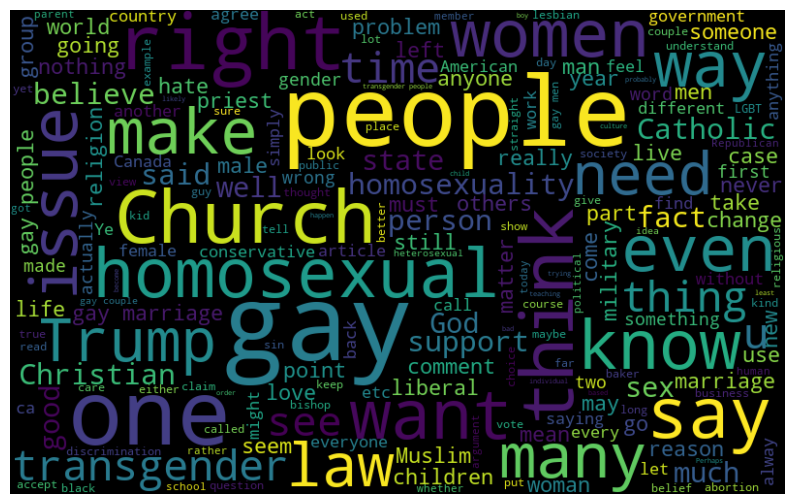

In [ ]:
male_comments = X[y['male'] == 1]['cleaned_text']
female_comments = X[y['female'] == 1]['cleaned_text']
lgbtq_comments = X[y['LGBTQ'] == 1]['cleaned_text']

from collections import Counter

male_freq = Counter([word for words_list in male_comments for word in words_list])
female_freq = Counter([word for words_list in female_comments for word in words_list])
lgbtq_freq = Counter([word for words_list in lgbtq_comments for word in words_list])

# Display the most common words in each category
print("Male-targeted comments common words:", male_freq.most_common(10))
print("Female-targeted comments common words:", female_freq.most_common(10))
print("LGBTQ-targeted comments common words:", lgbtq_freq.most_common(10))

# Function to generate word cloud
def generate_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(words))
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Generate word clouds for each category
generate_wordcloud([word for words_list in male_comments for word in words_list])
generate_wordcloud([word for words_list in female_comments for word in words_list])
generate_wordcloud([word for words_list in lgbtq_comments for word in words_list])


## II - Data Processing

In [22]:
data = pd.merge(X, y, left_index=True, right_index=True)
data_val = pd.merge(X_val, y_val, left_index=True, right_index=True)
data.head()

,index,string,cleaned_text,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,even up here.......BLACKS!,"[even, BLACKS]",0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,Blame men. There's always an excuse to blame ...,"[Blame, men, There, always, excuse, blame, men...",1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,2,You have no business making any comments on th...,"[You, business, making, comments, site, Craig,...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,3,"""Let's get the black folks and the white folks...","[Let, get, black, folks, white, folks, others,...",0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,4,I guess the issue is people not willing to put...,"[I, guess, issue, people, willing, put, stupid...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [23]:
y_train = data['y'].values
y_test = data_val['y'].values
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
data['string'] = data['string'].str.lower()
data.head()

,index,string,cleaned_text,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,even up here.......blacks!,"[even, BLACKS]",0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,blame men. there's always an excuse to blame ...,"[Blame, men, There, always, excuse, blame, men...",1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,2,you have no business making any comments on th...,"[You, business, making, comments, site, Craig,...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,3,"""let's get the black folks and the white folks...","[Let, get, black, folks, white, folks, others,...",0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,4,i guess the issue is people not willing to put...,"[I, guess, issue, people, willing, put, stupid...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [25]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['string'])
X_train_sequences = tokenizer.texts_to_sequences(data['string'])
X_test_sequences = tokenizer.texts_to_sequences(data_val['string'])
X_train_sequences

[[83, 60, 118, 632],
 [603, 117, 448, 201, 45, 1361, 2, 603, 117, 11, 1, 4348, 4, 65],
 [9,
  16,
  41,
  288,
  301,
  72,
  314,
  18,
  20,
  1231,
  8805,
  11,
  25,
  1,
  3057,
  3,
  1330,
  314,
  8,
  1100,
  999,
  1508,
  18,
  20,
  1231,
  130,
  2206,
  370,
  2005,
  1,
  787,
  3,
  1,
  1543,
  377,
  9,
  62,
  15,
  2150,
  33,
  20,
  1231,
  370,
  3,
  1,
  493,
  57,
  110,
  38,
  375,
  7944,
  54,
  1057,
  41,
  63,
  14,
  80,
  2,
  523,
  18,
  143,
  80,
  9,
  6351,
  38,
  3057,
  316,
  552,
  676,
  15,
  46,
  2,
  322,
  9,
  155,
  3,
  35,
  62,
  273,
  333,
  8,
  6,
  2486,
  2,
  38,
  2139],
 [486, 66, 1, 144, 411, 3, 1, 85, 411, 40, 373, 7745, 6945],
 [10,
  426,
  1,
  228,
  6,
  34,
  14,
  836,
  2,
  226,
  60,
  17,
  1,
  650,
  9834,
  4,
  3200,
  21,
  13,
  836,
  2,
  256,
  19,
  1460,
  3,
  2039],
 [52124,
  3,
  21,
  112,
  59,
  794,
  13,
  3659,
  41,
  14,
  2233,
  3659,
  50,
  120,
  4922,
  6278,
  2,
  1213,
  8,
 

In [26]:
# Padding the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=100, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=100, padding='post', truncating='post')

In [12]:
word_index = tokenizer.word_index
total_words = len(word_index)
print(total_words) #same as length of vocabulary

emb_len=len(tokenizer.index_word)+1

154221


In [16]:
# Input layer
input_layer = Input(shape=(100,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Bidirectional LSTM layer replaced with Attention layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer

# 1D Convolutional layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)

# GlobalMaxPooling1D layer
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
checkpoint_path = 'training/best_model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=True)

In [20]:
#Trainig the model
history = model.fit(X_train_padded,y_train,batch_size=128,epochs=2,validation_split=0.1,callbacks=[model_checkpoint_callback,early_stop])

Epoch 1/2
1892/1892 [==============================] - 1387s 725ms/step - loss: 0.2276 - accuracy: 0.9135 - val_loss: 0.2743 - val_accuracy: 0.8958
Epoch 2/2
1892/1892 [==============================] - 1324s 700ms/step - loss: 0.1749 - accuracy: 0.9299 - val_loss: 0.2688 - val_accuracy: 0.8933


In [21]:
model.load_weights(checkpoint_path)

In [27]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

1412/1412 [==============================] - 95s 67ms/step - loss: 0.2004 - accuracy: 0.9208
Validation Loss: 0.20036284625530243, Validation Accuracy: 0.920783519744873


In [28]:
x_test = pd.read_csv("./drive/My Drive/kaggle_data/test_x.csv")
x_test.head()

,index,string
0,0,OH yes - Were those evil Christian Missionarie...
1,1,He's considered a good candidate for a cyber-s...
2,2,"Lela, you admit no records exist to support yo..."
3,3,I'll take the iffy libertarian over the guy wh...
4,4,Shouldn't your handle be Republic of Uranus?


In [29]:
x_test['string'] = x_test['string'].str.lower()
X_test_sequences = tokenizer.texts_to_sequences(x_test['string'])
X_test_sequences

[[385,
  191,
  61,
  74,
  679,
  231,
  9316,
  75,
  4,
  1015,
  61,
  6156,
  32,
  1,
  3533,
  23,
  478,
  30,
  372,
  578,
  2,
  2312,
  9407,
  239,
  12512,
  7,
  17,
  74,
  9,
  717,
  191,
  10,
  93,
  99,
  60,
  5,
  395,
  50,
  19,
  9,
  99,
  60,
  1070],
 [303,
  859,
  5,
  92,
  845,
  11,
  5,
  9356,
  765,
  304,
  26,
  929,
  83,
  225,
  2739,
  33,
  44,
  136251,
  3199],
 [23664,
  9,
  1213,
  41,
  2576,
  1067,
  2,
  179,
  38,
  1012,
  4,
  5,
  14366,
  268,
  23601,
  24,
  91,
  126,
  1,
  3362,
  13,
  594,
  63,
  25,
  236,
  24,
  63,
  25,
  545,
  276,
  909,
  29,
  28,
  51,
  39,
  252,
  17,
  72,
  4,
  1,
  10392,
  718,
  28,
  224,
  11289,
  568,
  20344],
 [676,
  128,
  1,
  29058,
  4807,
  96,
  1,
  307,
  27,
  4804,
  365,
  7,
  1,
  199,
  431,
  81,
  22,
  59,
  32,
  1,
  98,
  25,
  1,
  6611,
  5605,
  11,
  59,
  703,
  174,
  192,
  40,
  72,
  4,
  44,
  1234,
  33,
  1,
  382,
  1001,
  624,
  128,
  36308,


In [30]:
X_test_padded = pad_sequences(X_test_sequences, maxlen=100, padding='post', truncating='post')

In [32]:
predictions = model.predict(X_test_padded)
print(predictions)

4181/4181 [==============================] - 276s 66ms/step
[[0.24281476]
 [0.00854104]
 [0.00908837]
 ...
 [0.20497848]
 [0.64672124]
 [0.6990469 ]]


In [34]:
predictions = pd.DataFrame(predictions)
output = pd.DataFrame(data={'ID': x_test['index'],'pred': predictions[0]})
output.to_csv('submission.csv', index=False)